In [ ]:
!wget --header="Host: mycityreport.s3-ap-northeast-1.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,mr;q=0.8" --header="Referer: https://github.com/sekilab/RoadDamageDetector" "https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/train.tar.gz" -c -O 'train.tar.gz'

--2021-03-05 08:04:44--  https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/train.tar.gz
Resolving mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)... 52.219.17.14
Connecting to mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)|52.219.17.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472626254 (1.4G) [application/x-tar]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>]   1.37G  32.8MB/s    in 44s     

2021-03-05 08:05:28 (32.2 MB/s) - ‘train.tar.gz’ saved [1472626254/1472626254]



In [ ]:
!tar -zxf ./train.tar.gz

In [ ]:
!mkdir /content/data
!mkdir /content/data/Images

In [ ]:
#converting pascal voc to the format that darknet needs
import os
import shutil
import numpy as np
import pandas as pd
from xml.etree import ElementTree
import random

base_dir = '/content/train/'
countries = ['Czech', 'India', 'Japan']
classes = ['D00', 'D10','D20', 'D40']

def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

for c in countries:
  xml_files = sorted(os.listdir(base_dir+c+'/annotations/xmls/'))
  image_files = sorted(os.listdir(base_dir+c+'/images/'))
  
  #Considering images which have objetcs
  for i in range(len(xml_files)):
    infile_xml = open(base_dir+c+'/annotations/xmls/'+xml_files[i])
    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    
    if root.find('object'):       #if there exist any object 
      objects = []
      for obj in root.iter('object'):
        objects.append(obj.find('name').text)
      if any(i in classes for i in objects):
        file_name = xml_files[i].split('.')[0]
        out_file = open('/content/data/Images/'+file_name+'.txt', 'w')
        for obj in root.iter('object'):   
          cls = obj.find('name').text
          if cls not in classes:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
          bb = convert((w,h), b)
          out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')
    
        shutil.move(base_dir+c+'/images/'+image_files[i], '/content/data/Images/')


In [ ]:
!rm -rf /content/train.tar.gz
!rm -rf /content/train

In [ ]:
image_dirs = sorted(['/content/data/Images/'+i for i in os.listdir('/content/data/Images') if i.split('.')[1] == 'jpg'])
print('total no of images: ',len(image_dirs))

random.shuffle(image_dirs)

train_images = image_dirs[:10000]
val_images = image_dirs[10000:11000]
test_images = image_dirs[11000:]

print('no of train samples:', len(train_images))
print('no of val samples:', len(val_images))
print('no of test samples:', len(test_images))

def list_to_file(dir, my_list):
  with open(dir, 'w') as f:
    for item in my_list:
      f.write("%s\n" % item)

list_to_file('/content/data/train.txt', train_images)
list_to_file('/content/data/val.txt', val_images)
list_to_file('/content/data/test.txt', test_images)

total no of images:  12195
no of train samples: 10000
no of val samples: 1000
no of test samples: 1195


In [ ]:
!mv /content/obj.names /content/data/
!mv /content/obj.data /content/data/

In [1]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 14730, done.
remote: Total 14730 (delta 0), reused 0 (delta 0), pack-reused 14730
Receiving objects: 100% (14730/14730), 13.27 MiB | 24.90 MiB/s, done.
Resolving deltas: 100% (10020/10020), done.


In [2]:
%cd /content/darknet/
!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
           

In [ ]:
%cd /content/
!wget https://pjreddie.com/media/files/darknet53.conv.74

/content
--2021-03-03 11:11:58--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  23.0MB/s    in 7.4s    

2021-03-03 11:12:06 (21.0 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [ ]:
!cp /content/darknet/cfg/yolov3.cfg /content/darknet/cfg/yolo-obj.cfg

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/darknet/
!./darknet detector train /content/data/obj.data cfg/yolo-obj.cfg /content/drive/MyDrive/yolo/yolo-obj_last.weights -dont_show 

/content/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
yolo-obj
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 B

In [ ]:
#val map
%cd /content/darknet/
!./darknet detector map /content/data/obj.data cfg/yolo-obj.cfg /content/drive/MyDrive/yolo/yolo-obj_last.weights

/content/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sh

In [ ]:
#test map
%cd /content/darknet/
!./darknet detector map /content/data/obj.data cfg/yolo-obj.cfg /content/drive/MyDrive/yolo/yolo-obj_last.weights

/content/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sh

### Inference

In [ ]:
from IPython.display import display, Image

In [ ]:
images = [/content/data/Images/Czech_003362.jpg,/content/data/Images/India_002894.jpg,/content/data/Images/Japan_004720.jpg]

/content/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sh

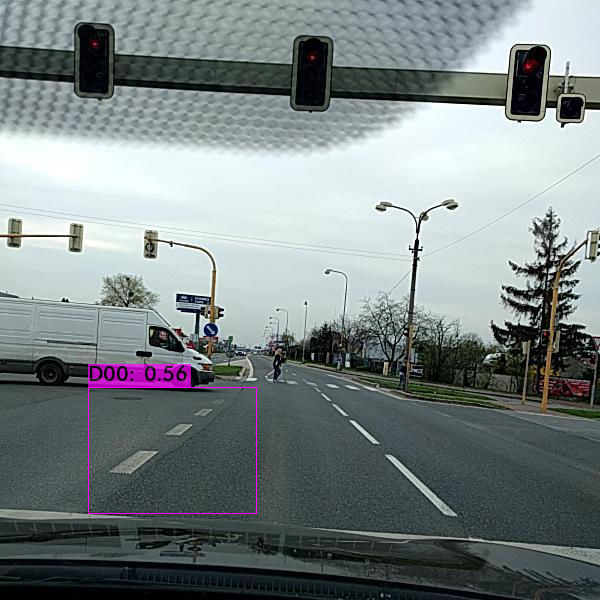

In [ ]:
%cd /content/darknet/
!./darknet detector test /content/data/obj.data /content/darknet/cfg/yolo-obj.cfg \
/content/drive/MyDrive/yolo/yolo-obj_last.weights /content/data/Images/Czech_003362.jpg -dont_show

display(Image(filename='/content/darknet/predictions.jpg'))

/content/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sh

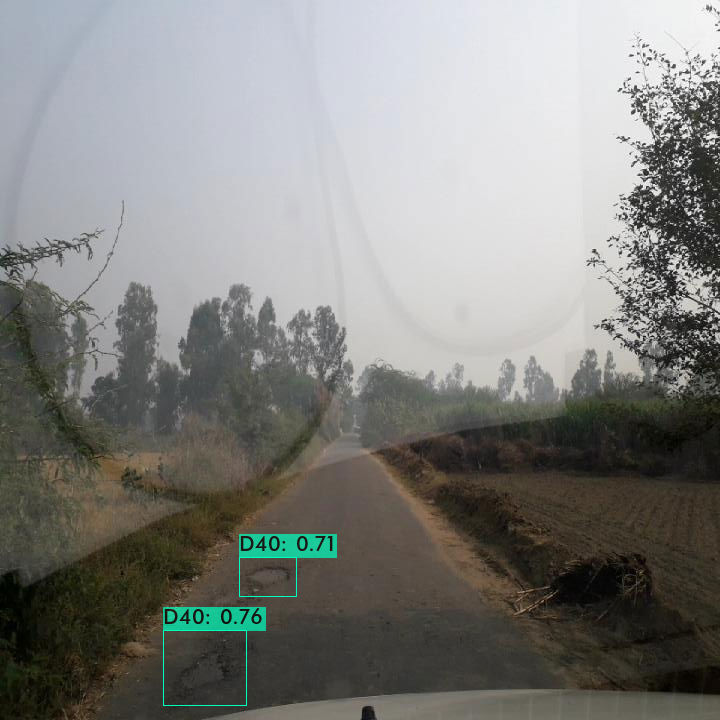

In [ ]:
%cd /content/darknet/
!./darknet detector test /content/data/obj.data /content/darknet/cfg/yolo-obj.cfg \
/content/drive/MyDrive/yolo/yolo-obj_last.weights /content/data/Images/India_002894.jpg -dont_show

display(Image(filename='/content/darknet/predictions.jpg'))

/content/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sh

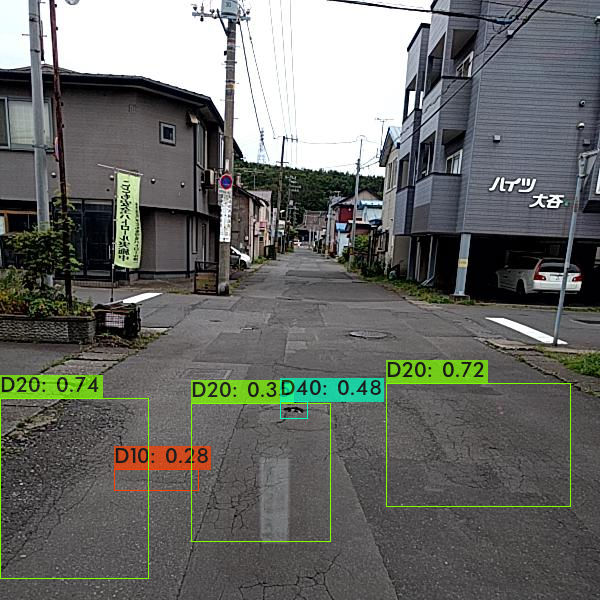

In [ ]:
%cd /content/darknet/
!./darknet detector test /content/data/obj.data /content/darknet/cfg/yolo-obj.cfg \
/content/drive/MyDrive/yolo/yolo-obj_last.weights /content/data/Images/Japan_004720.jpg -dont_show

display(Image(filename='/content/darknet/predictions.jpg'))

In [4]:
%cd /content/darknet/
!./darknet detector demo /content/obj.data /content/yolo-obj.cfg  \
  /content/drive/MyDrive/yolo/yolo-obj_final.weights /content/drive/MyDrive/input_2.mp4 -dont_show \
  -out_filename '/content/output.avi'

/content/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Demo
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
  

In [ ]:
!mv /content/output.avi /content/drive/MyDrive/

In [ ]:
%cd /content/data